# Explore $100^{th}$ level of `q` variable

In [1]:
import os
import json 
import subprocess
import importlib

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe

import xbitinfo as xb
import xarray as xr

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

---

In [3]:
# load data
path_to_data = './data/multi-level/cams_hej6_pl_q_20191201.nc'  # change this
ds = xr.open_dataset(path_to_data)
ds = ds.sel(level=100)

In [4]:
ds.level.size

1

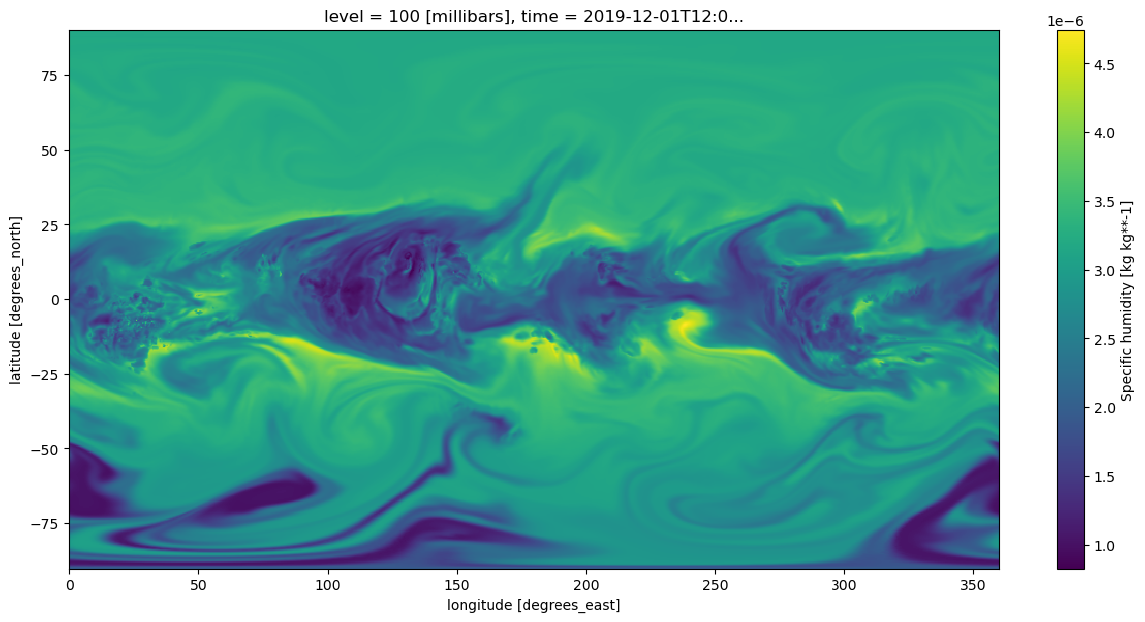

In [5]:
fig, ax = plt.subplots(figsize=(15, 7))
ds['q'].plot(ax=ax)

---

In [ ]:
at_least_zero = lambda x: max(x, 0)

chunk_long, chunk_lat = [100, 41] # for int division
vrbs = ['longitude', 'latitude']
var = 'latitude'

dss = {}
dss_bitrounded = {}
dss_kbits = {}

long_c = int(ds.longitude.size / chunk_long)
lat_c = int(ds.latitude.size / chunk_lat)
lvl_c = int(ds.level.size)

for l in range(lvl_c):
    
    dss[l] = []
    dss_bitrounded[l] = []
    dss_kbits[l] = []
    
    for i in range(long_c):
        for j in range(lat_c):
            ds_lvl = ds#.isel(level=l)
            temp_ds = ds_lvl.isel(longitude=slice(i*chunk_long, (i+1)*chunk_long),
                                  latitude=slice(j*chunk_lat, (j+1)*chunk_lat))
            dss[l].append(temp_ds)
            temp_info_pbit = xb.get_bitinformation(temp_ds, dim=var, implementation="python")
            temp_keepbits = xb.get_keepbits(temp_info_pbit, 0.99)
            # temp_keepbits = temp_keepbits.map(at_least_zero)
            dss_kbits[l].append(temp_keepbits)
            temp_ds_bitrounded = xb.xr_bitround(temp_ds, temp_keepbits)
            dss_bitrounded[l].append(temp_ds_bitrounded)
            
            temp_ds_bitrounded.to_compressed_zarr(f"bitrounded_compressed_{i}_{j}.zarr", mode='w')

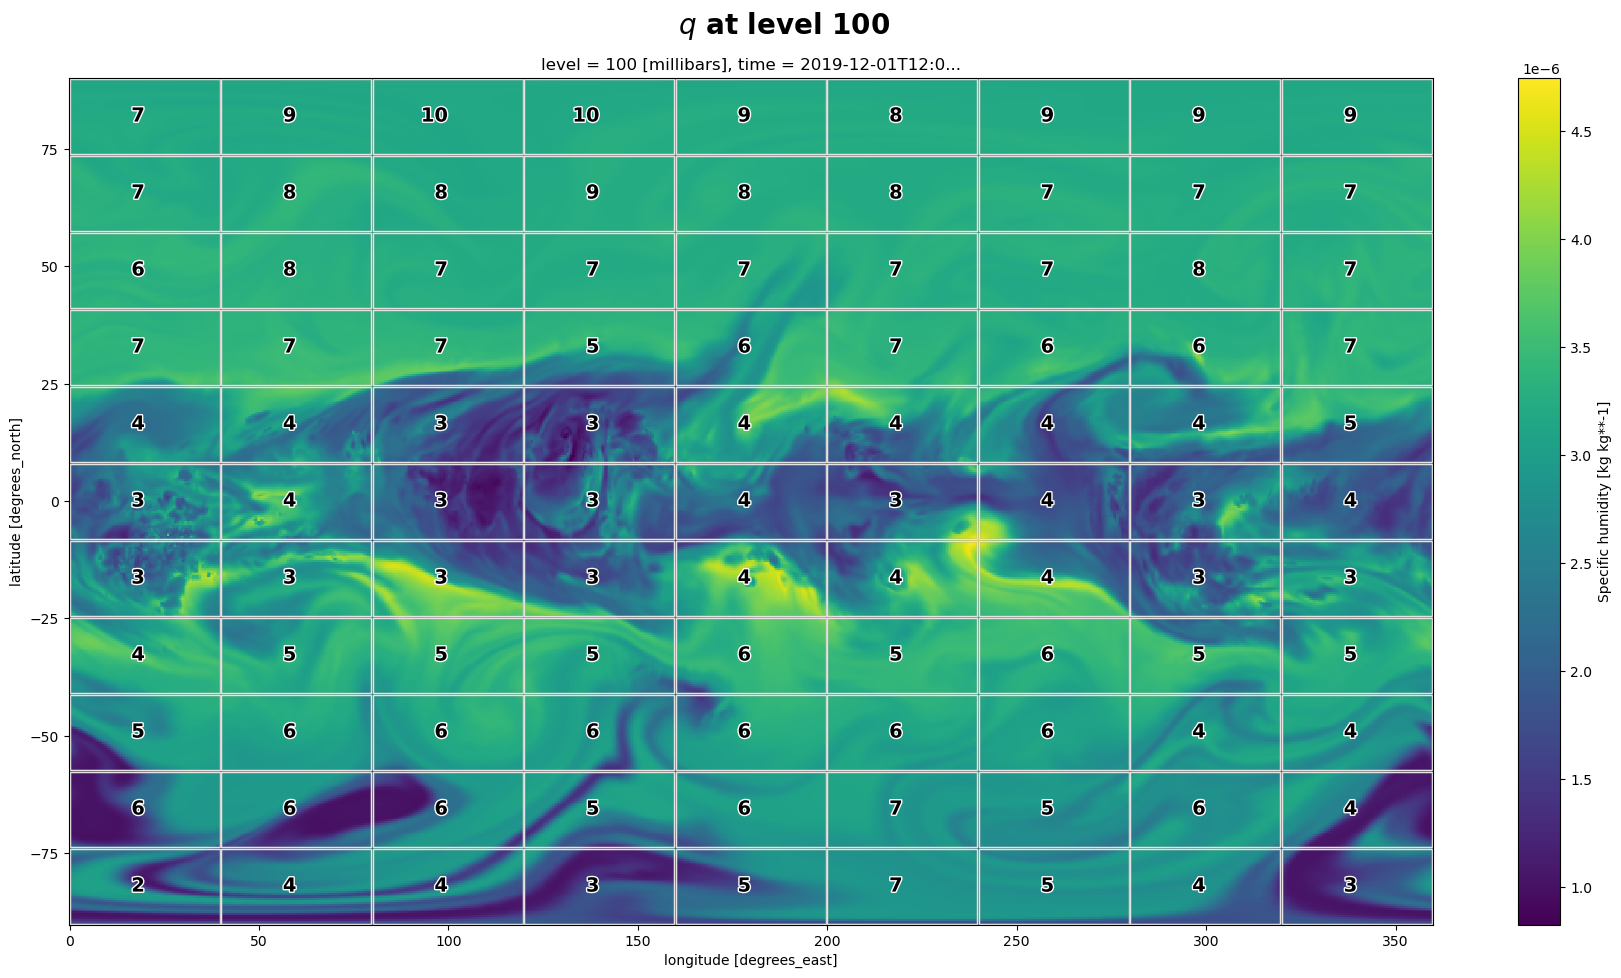

In [7]:
for l in range(lvl_c):
    
    fig, ax = plt.subplots(figsize=(22, 11))

    ds['q'].plot(ax=ax)

    for i in range(len(dss_bitrounded[l])):
        lats = dss[l][i].latitude
        longs = dss[l][i].longitude
        
        x = float(min(longs[0], longs[-1]))
        y = float(min(lats[0], lats[-1]))
        w = float(abs(longs[0] - longs[-1]))
        h = float(abs(lats[0] - lats[-1]))
        
        rect = mpl.patches.Rectangle((x, y), width = w, height = h,
                                    facecolor = "none", edgecolor = "#E5E4E2",
                                    path_effects=[pe.withStroke(linewidth=1, foreground="gray")],
                                    label='xxx')
        ax.add_patch(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/2.0
        ax.annotate(
            f"""
            {int(dss_kbits[l][i].q):2}
            """,
            (cx, cy), color='k', weight='bold', fontsize=14, ha='right', va='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='w')]
        )
    
    level = int(dss_bitrounded[l][0].level)
    fig.text(.402, .92, f'$q$ at level {level}', weight='bold', fontsize=20)

    fig.show()

In [8]:
!du -chs *.zarr | grep total

9.3M	total


In [9]:
!du -hs *.zarr

96K	bitrounded_compressed_0_0.zarr
96K	bitrounded_compressed_0_10.zarr
96K	bitrounded_compressed_0_1.zarr
96K	bitrounded_compressed_0_2.zarr
96K	bitrounded_compressed_0_3.zarr
96K	bitrounded_compressed_0_4.zarr
96K	bitrounded_compressed_0_5.zarr
96K	bitrounded_compressed_0_6.zarr
96K	bitrounded_compressed_0_7.zarr
96K	bitrounded_compressed_0_8.zarr
96K	bitrounded_compressed_0_9.zarr
96K	bitrounded_compressed_1_0.zarr
96K	bitrounded_compressed_1_10.zarr
96K	bitrounded_compressed_1_1.zarr
96K	bitrounded_compressed_1_2.zarr
96K	bitrounded_compressed_1_3.zarr
96K	bitrounded_compressed_1_4.zarr
96K	bitrounded_compressed_1_5.zarr
96K	bitrounded_compressed_1_6.zarr
96K	bitrounded_compressed_1_7.zarr
96K	bitrounded_compressed_1_8.zarr
96K	bitrounded_compressed_1_9.zarr
96K	bitrounded_compressed_2_0.zarr
96K	bitrounded_compressed_2_10.zarr
96K	bitrounded_compressed_2_1.zarr
96K	bitrounded_compressed_2_2.zarr
96K	bitrounded_compressed_2_3.zarr
96K	bitrounded_compressed_2_4.zarr
96K	bitrounded_co

In [10]:
!rm -r *.zarr

In [11]:
info_per_bit = xb.get_bitinformation(ds, dim='latitude', implementation='python')

keepbits = xb.get_keepbits(info_per_bit, 0.99)

ds_bitrounded = xb.xr_bitround(ds, keepbits)

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
keepbits.q.values

array([6])

In [13]:
ds_bitrounded.to_compressed_zarr("bitrounded_compressed.zarr", mode="w")
ds.to_compressed_zarr("compressed.zarr", mode="w")
ds.to_zarr(
    "original.zarr", mode="w", encoding={v: {"compressor": None} for v in ds.data_vars}
);

In [14]:
!du -hs *.zarr

260K	bitrounded_compressed.zarr
1.2M	compressed.zarr
1.7M	original.zarr


In [15]:
!rm -r *.zarr